In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, KFold
import matplotlib.gridspec as gridspec
from sklearn.svm import SVC
import pickle

plt.rcParams.update({
    "text.usetex": True,
    'text.latex.preamble': r'\usepackage[cm]{sfmath}',
    'font.family': 'sans-serif',
    #'font.sans-serif': 'cm'
})



df = pd.read_csv('../data/0_labelled_documents.csv')

df = (df
      .sort_values('id')
      .sample(frac=1, random_state=1)
      .reset_index(drop=True)
)

print(df.shape)

seen_index = df[df['seen']==1].index
unseen_index = df[df['seen']==0].index
new_index = df[(df['seen']==1) & (df['ar5']==0)].index
rel_index = df[df['relevant']==1].index
r_index = df[df["random_sample"]==1].index
physical_index = df[df['physical_tags']==1].index

(2630, 252)


0
1


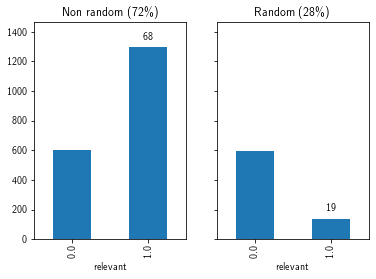

In [2]:
fig, axs = plt.subplots(1,2, sharey=True)
for i, r in enumerate(["Non random", "Random"]):
    print(i)
    sub_df = df[df['random_sample']==i]
    sub_df.groupby('relevant').size().plot.bar(ax=axs[i])
    axs[i].set_title(f"{r} ({sub_df.shape[0]/df.shape[0]:.0%})".replace("%","\%"))
    
    n = sub_df[sub_df['relevant']==1].shape[0]
    n_share = n/sub_df.shape[0]
    axs[i].text(1,n+df.shape[0]*0.02,f"{n_share:.0%}",ha="center")
    axs[i].set_ylim(ymax=axs[i].get_ylim()[1]+df.shape[0]*0.02)

Validation on 263 samples (10%)
Training with 2367 samples (90%)
Validation on 263 samples (10%)
Training with 2367 samples (90%)
Validation on 263 samples (10%)
Training with 2367 samples (90%)
Validation on 263 samples (10%)
Training with 2367 samples (90%)
Validation on 263 samples (10%)
Training with 2367 samples (90%)
Validation on 263 samples (10%)
Training with 2367 samples (90%)
Validation on 263 samples (10%)
Training with 2367 samples (90%)
Validation on 263 samples (10%)
Training with 2367 samples (90%)
Validation on 263 samples (10%)
Training with 2367 samples (90%)
Validation on 263 samples (10%)
Training with 2367 samples (90%)


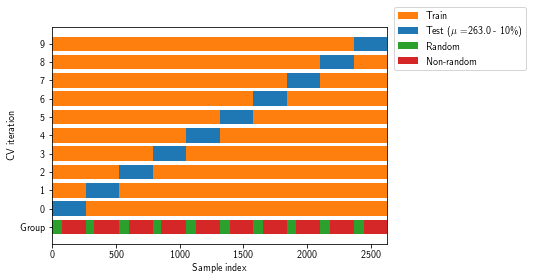

In [3]:
from sklearn.model_selection import KFold


def plot_cv(n_splits, df, ax, discard_nonrandom=True, validate_nonrandom=False):
    
    kf = KFold(n_splits=n_splits)
    test_sizes = []
    for i, (train, test) in enumerate(kf.split(df.relevant)):
        tdf_random = df.loc[(df.index.isin(test)) & (df['random_sample']==1),:].index
        test_n = len(tdf_random)
        if validate_nonrandom:
            test_n = len(test)
        test_sizes.append(test_n)
        test_share = test_n/df.shape[0]
        print(f"Validation on {test_n} samples ({test_share:.0%})")

        train_bar = ax.barh(i,len(df.relevant)-test[-1],left=test[-1],color="C1")
        ax.barh(i,test[0], color="C1")

        test_bar = ax.barh(i, test_n, left=test[0],color="C0")
        if discard_nonrandom:
            discarded_test_bar = ax.barh(i, len(test)-test_n, left=test[0]+test_n,color="C0", alpha=0.5)
            print(f"Training with {len(train)} samples ({len(train)/df.shape[0]:.0%})")
        else:
            discarded_test_bar = None
            ax.barh(i, len(test)-test_n, left=test[0]+test_n,color="C1")
            print(f"Training with {df.shape[0]-test_n} samples ({1-test_share:.0%})")

        rgroup = ax.barh(-1, len(tdf_random), left=test[0],color="C2")
        nrgroup = ax.barh(-1, len(test)-len(tdf_random), left=test[0]+len(tdf_random),color="C3")

    ax.set_xlabel('Sample index')
    ax.set_ylabel('CV iteration')
    ax.set_yticks(range(-1,n_splits))
    ax.set_yticklabels(["Group"]+list(range(n_splits)))
    ax.set_xlim(xmax=df.shape[0])
    
    mean_test = np.mean(test_sizes)
    mean_test_share = mean_test/df.shape[0]
    
    test_label = f"Test ($\mu=${mean_test} - {mean_test_share:.0%})".replace("%","\%")
    
    if discard_nonrandom:
        labels = ["Train",test_label,"Non-random test (discarded)","Random","Non-random"]
    else:
        labels = ["Train",test_label,"Random","Non-random"]
        
    bars =  [train_bar, test_bar, discarded_test_bar, rgroup, nrgroup]
    
    ax.legend(
        [x for x in bars if x is not None],
        labels,
        loc=(1.02, .8)
    )
    
fig, ax = plt.subplots()  
plot_cv(10, df, ax, False, True)
    

Validation on 136 samples (5%)
Training with 2104 samples (80%)
Validation on 139 samples (5%)
Training with 2104 samples (80%)
Validation on 154 samples (6%)
Training with 2104 samples (80%)
Validation on 152 samples (6%)
Training with 2104 samples (80%)
Validation on 152 samples (6%)
Training with 2104 samples (80%)


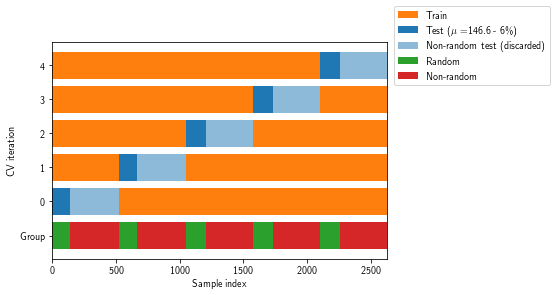

In [4]:
fig, ax = plt.subplots()  
plot_cv(5, df, ax, True)

Validation on 136 samples (5%)
Training with 2494 samples (95%)
Validation on 139 samples (5%)
Training with 2491 samples (95%)
Validation on 154 samples (6%)
Training with 2476 samples (94%)
Validation on 152 samples (6%)
Training with 2478 samples (94%)
Validation on 152 samples (6%)
Training with 2478 samples (94%)


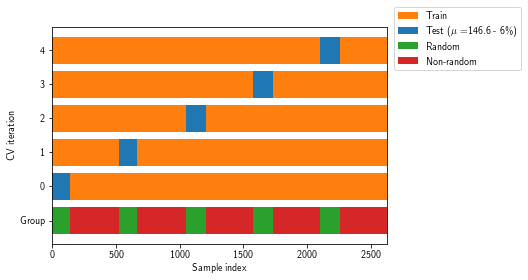

In [5]:
fig, ax = plt.subplots()  
plot_cv(5, df, ax, False)

Validation on 232 samples (9%)
Training with 2398 samples (91%)
Validation on 251 samples (10%)
Training with 2379 samples (90%)
Validation on 250 samples (10%)
Training with 2380 samples (90%)


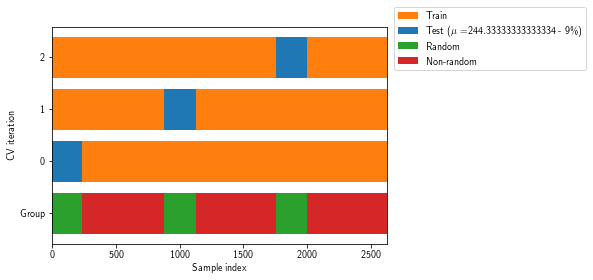

In [6]:
fig, ax = plt.subplots()  
plot_cv(3, df, ax, False)

Validation on 75 samples (3%)
Training with 2555 samples (97%)
Validation on 61 samples (2%)
Training with 2569 samples (98%)
Validation on 74 samples (3%)
Training with 2556 samples (97%)
Validation on 65 samples (2%)
Training with 2565 samples (98%)
Validation on 74 samples (3%)
Training with 2556 samples (97%)
Validation on 80 samples (3%)
Training with 2550 samples (97%)
Validation on 78 samples (3%)
Training with 2552 samples (97%)
Validation on 74 samples (3%)
Training with 2556 samples (97%)
Validation on 74 samples (3%)
Training with 2556 samples (97%)
Validation on 78 samples (3%)
Training with 2552 samples (97%)


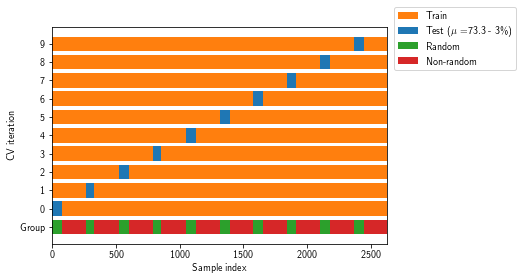

In [7]:
fig, ax = plt.subplots()  
plot_cv(10, df, ax, False)

In [8]:
def KFoldRandom(n_splits, X, no_test, shuffle=False, discard=True):
    kf = KFold(n_splits=n_splits, shuffle=shuffle)
    for train, test in kf.split(X):
        if not discard:
            train = list(train) +  [x for x in test if x in no_test]
        test = [x for x in test if x not in no_test]
        yield (train, test)
        
kf = KFoldRandom(5, df.relevant, df[df['random_sample']!=1].index, discard=False)
print(len(next(kf)[1]))

136


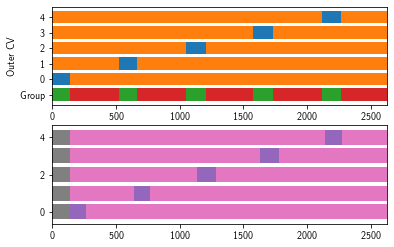

In [9]:
fig, axs = plt.subplots(2)  
n_splits = 5
outer_cv = KFoldRandom(n_splits, df.index, df[df['random_sample']!=1].index, discard=False)
for k, (train, test) in enumerate(outer_cv): 
    ax = axs[0]
    train_bar = ax.barh(k,len(df.relevant)-len(test)-test[0],left=test[0]+len(test),color="C1")
    ax.barh(k,test[0], color="C1")
    test_bar = ax.barh(k, len(test), left=test[0],color="C0")
    
    ax.set_xlim(xmax=df.shape[0])
    
    rgroup = ax.barh(-1, len(test), left=test[0],color="C2")
    nrgroup = ax.barh(-1, test[-1], left=test[0]+len(test),color="C3")
    
    inner_cv = KFoldRandom(5, train, df[df['random_sample']!=1].index, discard=False)
    inner_scores = []
    
    ax.set_xlabel('Sample index')
    ax.set_ylabel('Outer CV')
    ax.set_yticks(range(-1,n_splits))
    ax.set_yticklabels(["Group"]+list(range(n_splits)))
    ax.set_xlim(xmax=df.shape[0])
    
    
    if k==0:
        
        ax = axs[1]
        ax.set_xlim(xmax=df.shape[0])
        for l, (l_train, l_test) in enumerate(inner_cv):
            
            #l_train = np.sort(np.array(train))[l_train]
            #l_test = np.sort(np.array(train))[l_test]
            ax.barh(l, len(test), color="grey")
            
            ax.barh(l, len(l_test), left=len(test)+l_test[0],color="C4")
            
            ax.barh(l, len(train)-len(l_test)-l_test[0], left=l_test[0]+len(l_test)+len(test),color="C6")
            
            ax.barh(l, l_test[0], left=len(test),color="C6")
            
            #break

1000.0
1000.0
1000.0
1000.0


/home/max/.local/lib/python3.6/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
No handles with labels found to put in legend.


1000.0


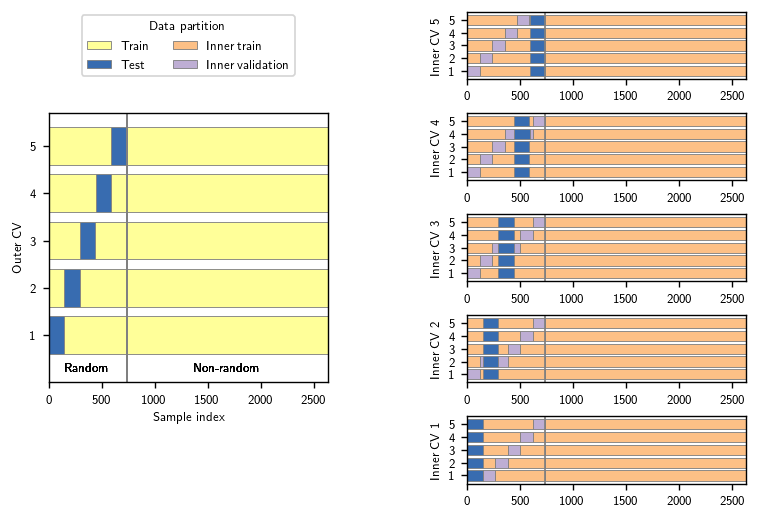

In [10]:
fig = plt.figure(figsize=(7.2,5), dpi=125)  
gs = fig.add_gridspec(5, 2, hspace=0.5, wspace=0.5)

plt.rcParams["font.size"] = 7



ec = "grey"
lw = 0.5

C0 = "#ffff99"
C1 = "#fdc086"
C2 = "#386cb0"
C3 = "#beaed4"
C4 = "#7fc97f"
C5 = "#f0027f"

n_splits = 5
kf = KFold(n_splits=n_splits)

df = df.sort_values('random_sample',ascending=False).reset_index(drop=True)

X = df[df['random_sample']==1].index

for k, (train, test) in enumerate(kf.split(X)):
    
    ax = plt.subplot(gs[1:4,0])
    #Test
    test_bar = ax.barh(k, len(test),left=test[0], color=C2, ec=ec, lw=lw)
    #Train
    train_bar = ax.barh(k, test[0], color=C0, ec=ec, lw=lw)
    ax.barh(k, df.shape[0]-test[-1], left=test[-1], color=C0, ec=ec, lw=lw)
    
    ax.axvline(X.shape[0], color="grey",lw=1)
    ax.text(X.shape[0]/2, -0.7, "Random", ha="center", va="center")
    ax.text(X.shape[0]+(df.shape[0]-X.shape[0])/2, -0.7, "Non-random", ha="center", va="center")
    
    ax.set_xlabel('Sample index')
    ax.set_ylabel('Outer CV')
    ax.set_yticks(range(n_splits))
    ax.set_yticklabels(list(range(1,n_splits+1)))
    #ax.set_yticklabels(["1",2,"2",5,"5"])
    ax.set_ylim([-1,n_splits-0.3])
    ax.set_xlim(xmax=df.shape[0])
    print(ax.get_xticks()[2])
    
    inner_kf = KFold(n_splits=n_splits)
    ax = plt.subplot(gs[4-k,1])
    ax.set_yticks(range(n_splits))
    ax.set_yticklabels(list(range(1,n_splits+1)))

    ax.set_xlim(xmax=df.shape[0]+0.5, xmin=0)
    
    ax.axvline(X.shape[0], color="grey",lw=1)
    
    ax.set_ylabel(f'Inner CV {k+1}')

    for l, (l_train, l_test) in enumerate(inner_kf.split(train)):
        l_test = train[l_test]
        l_train = train[l_train]
        
        ax.barh(l, len(test),left=test[0], color=C2, ec=ec, lw=lw)
        
        if l_test[0]+len(l_test) in test:
            inner_val = ax.barh(l, test[0]-l_test[0], left=l_test[0],color=C3, ec=ec,lw=lw)
            ax.barh(l, len(l_test)-(test[0]-l_test[0]), left=test[-1]+1,color=C3, ec=ec,lw=lw)
            
        else:
            ax.barh(l, len(l_test), left=l_test[0],color=C3, ec=ec,lw=lw)
            
        inner_train = ax.barh(l, np.min([l_test.min(),test.min()]), color=C1, ec=ec,lw=lw)
        
        bar_left = np.max([l_test.max(),test.max()])
        ax.barh(l, X.shape[0]-bar_left, left=bar_left, color=C1, ec=ec, lw=lw)
        
        if l_test[-1] < test[0]:
            ax.barh(l, test[0]-l_test[-1], left=l_test[-1], color=C1, ec=ec, lw=lw)
            
        if test[-1] < l_test[0]:
            ax.barh(l, l_test[0]-test[-1], left=test[-1], color=C1, ec=ec, lw=lw)
            
        ax.barh(l, df.shape[0]-X.shape[0], left=X.shape[0], color=C1, ec=ec, lw=lw)
        
        
ax = fig.add_subplot(gs[0,0]) 
ax.axis('off')
ax.legend()    

bars =  [train_bar, test_bar, inner_train, inner_val]
labels = ["Train", "Test", "Inner train", "Inner validation"]

ax.legend(
    [x for x in bars if x is not None],
    labels,
    ncol=2,
    loc="center",
    title="Data partition"
    #loc=(1.02, .8)
)
        
plt.savefig("../figures/si_figure_2.pdf", bbox_inches="tight")
plt.savefig("../figures/si_figure_2.png", dpi=250, bbox_inches="tight")
plt.savefig("../figures/si_figure_2.jpg", dpi=250, bbox_inches="tight")
plt.savefig("../figures/si_figure_2.tiff", dpi=250, bbox_inches="tight")


Text(0, 0, '')

In [97]:
test

array([80, 81, 82, 83, 84, 85, 86])

In [37]:
train

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79])

In [10]:
revectorize = True

X_exists = os.path.isfile(f'../data/X_{df.shape[0]}.npz')

if revectorize is True or X_exists is False:
    print("running vectorisation again")
    vec = TfidfVectorizer(
        ngram_range=(1,2),
        min_df=15, max_df=0.8, strip_accents='unicode', 
        max_features=20000,
        #tokenizer=snowball_stemmer()
    )

    X = vec.fit_transform(df['content'].astype("str"))   
    with open (f'../data/vec_{df.shape[0]}.pickle','wb') as f:
        pickle.dump(vec, f)
    import scipy.sparse
    scipy.sparse.save_npz(f'../data/X_{df.shape[0]}.npz', X)
else:
    print("loading feature matrix")
    with open (f'../data/vec_{df.shape[0]}.pickle','rb') as f:
        vec = pickle.load(f)
        X = scipy.sparse.load_npz(f'../data/X_{df.shape[0]}.npz')
        
X.shape
y = df.relevant


        


running vectorisation again


In [23]:
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
import tensorflow as tf
import tensorflow_addons as tfa

MODEL_NAME = 'distilbert-base-uncased'

tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)


def construct_encodings(x, tkzr, max_len, trucation=True, padding=True):
    return tkzr(x, max_length=max_len, truncation=trucation, padding=padding)

def construct_tfdataset(encodings, y=None):
    if y:
        return tf.data.Dataset.from_tensor_slices((dict(encodings),y))
    else:
        # this case is used when making predictions on unseen samples after training
        return tf.data.Dataset.from_tensor_slices(dict(encodings))
    
def create_predictor(model, model_name, max_len):
    tkzr = DistilBertTokenizer.from_pretrained(model_name)
    def predict_proba(text):
        x = text

        encodings = construct_encodings(x, tkzr, max_len=max_len)
        tfdataset = construct_tfdataset(encodings)
        tfdataset = tfdataset.batch(1)

        preds = model.predict(tfdataset).logits
        preds = tf.keras.activations.sigmoid(tf.convert_to_tensor(preds)).numpy()
        return preds#[0][0]

    return predict_proba

def create_train_val(x,y,train,val):
    train_encodings = tokenizer(list(x[train].values),
                                truncation=True,
                                padding=True)
    val_encodings = tokenizer(list(x[val].values),
                                truncation=True,
                                padding=True) 
    
    train_dataset = tf.data.Dataset.from_tensor_slices((
        dict(train_encodings),
        list(y[train].values)
    ))
    val_dataset = tf.data.Dataset.from_tensor_slices((
        dict(val_encodings),
        list(y[val].values)
    ))
    
    
    MAX_LEN = train_dataset._structure[0]['input_ids'].shape[0]
    
    return train_dataset, val_dataset, MAX_LEN

def init_model(MODEL_NAME, num_labels, params):
    model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_labels)  
    optimizer = tfa.optimizers.AdamW(learning_rate=params['learning_rate'], weight_decay=params['weight_decay'])

    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    metrics = tf.metrics.BinaryAccuracy()
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics
    )
    return model

def create_predictor(model, model_name, max_len):
    tkzr = DistilBertTokenizer.from_pretrained(model_name)
    def predict_proba(text):
        x = text

        encodings = construct_encodings(x, tkzr, max_len=max_len)
        tfdataset = construct_tfdataset(encodings)
        tfdataset = tfdataset.batch(1)

        preds = model.predict(tfdataset).logits
        preds = tf.keras.activations.sigmoid(tf.convert_to_tensor(preds)).numpy()
        return preds#[0][0]

    return predict_proba
    
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score, precision_recall_curve, f1_score
from sklearn.metrics import precision_score, recall_score

def evaluate_preds(y_true, y_pred):
    try:
        roc_auc = roc_auc_score(y_true, y_pred)
    except:
        roc_auc = np.NaN
    f1 = f1_score(y_true, y_pred.round())
    p, r = precision_score(y_true, y_pred.round()), recall_score(y_true, y_pred.round())
    acc = accuracy_score(y_true, y_pred.round())
    print(f"ROC AUC: {roc_auc:.0%}, F1: {f1:.1%}, precision: {p:.1%}, recall {r:.1%}, acc {acc:.0%}")
    return {"ROC AUC": roc_auc, "F1": f1, "precision": p, "recall": r, "accuracy": acc}


In [22]:
print(f"{np.NaN:.0%}")

nan%


In [34]:
bert_params = {
  "batch_size": [16, 32],
  "weight_decay": (0, 0.3),
  "learning_rate": (1e-5, 5e-5),
  "num_epochs": [2, 3, 4]
}
import itertools
def product_dict(**kwargs):
    keys = kwargs.keys()
    vals = kwargs.values()
    for instance in itertools.product(*vals):
        yield dict(zip(keys, instance))
            
param_space = list(product_dict(**bert_params))
len(param_space)

24

In [29]:
from multiprocessing import Pool
from functools import partial

outer_cv = KFoldRandom(5, df.head(20).index, df[df['random_sample']!=1].index)

outer_scores = []
clfs = []


def train_eval_bert(params, df, train, test):
    train_dataset, val_dataset, MAX_LEN = create_train_val(df['content'], df['relevant'], train, test)
    
    print("training bert with these params")
    print(params)
    model = init_model('distilbert-base-uncased', 1, params)
    model.fit(train_dataset.shuffle(100).batch(params['batch_size']),
              epochs=params['num_epochs'],
              batch_size=16,
    )

    clf = create_predictor(model, MODEL_NAME, MAX_LEN)
    
    y_pred = clf(list(df['content'][test].values))
    eps = evaluate_preds(df['relevant'][test], y_pred[:,0])  
    for key, value in params.items():
        eps[key] = value
    return eps

parallel=False

for k, (train, test) in enumerate(outer_cv):    
    inner_cv = KFoldRandom(5, train, df[df['random_sample']!=1].index, discard=False)
    inner_scores = []
    for l, (l_train, l_test) in enumerate(inner_cv):
        cv_results = []
        if parallel:
            with Pool(5) as p:
                cv_results = p.map(partial(train_eval_bert, df=df, train=l_train, test=l_test), param_space)
        else:
            for pr in param_space:
                cv_results.append(train_eval_bert(pr, df=df, train=l_train, test=l_test))
        
        break
        
    
    break

training bert with these params
{'batch_size': 16, 'weight_decay': 0, 'learning_rate': 1e-05, 'num_epochs': 2}


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'activation_13', 'vocab_layer_norm', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_99', 'pre_classifier', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

Epoch 1/2


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


1/1 [==============================] - 20s 20s/step - loss: 0.6859 - binary_accuracy: 0.3571
Epoch 2/2
1/1 [==============================] - 14s 14s/step - loss: 0.6803 - binary_accuracy: 0.3571


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


ROC AUC: nan%, F1: 0.0%, precision: 0.0%, recall 0.0%, acc 0%


/home/max/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


training bert with these params
{'batch_size': 16, 'weight_decay': 0, 'learning_rate': 1e-05, 'num_epochs': 3}


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'activation_13', 'vocab_layer_norm', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_119', 'pre_classifier', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use 

Epoch 1/3


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


1/1 [==============================] - 21s 21s/step - loss: 0.7210 - binary_accuracy: 0.3571
Epoch 2/3
1/1 [==============================] - 15s 15s/step - loss: 0.7080 - binary_accuracy: 0.3571
Epoch 3/3
1/1 [==============================] - 15s 15s/step - loss: 0.7047 - binary_accuracy: 0.3571


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


ROC AUC: nan%, F1: 0.0%, precision: 0.0%, recall 0.0%, acc 100%


/home/max/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1493: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/home/max/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/max/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
cv_results[0]

{'ROC AUC': nan,
 'F1': 0.0,
 'precision': 0.0,
 'recall': 0.0,
 'accuracy': 0.0,
 'batch_size': 16,
 'weight_decay': 0,
 'learning_rate': 1e-05,
 'num_epochs': 2}

In [31]:
pd.DataFrame.from_dict(cv_results)

,ROC AUC,F1,precision,recall,accuracy,batch_size,weight_decay,learning_rate,num_epochs
0,NaN,0.0,0.0,0.0,0.0,16,0,0.00001,2
1,NaN,0.0,0.0,0.0,1.0,16,0,0.00001,3


In [89]:
########################################
p_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
]

def KFoldRandom(n_splits, index, no_test, shuffle=False, discard=True):
    kf = KFold(n_splits=n_splits, shuffle=shuffle)
    for train, test in kf.split(index):
        if not discard:
            train = list(train) +  [x for x in test if x in no_test]
        test = [x for x in test if x not in no_test]
        yield (index[train], index[test])

In [121]:
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score, precision_recall_curve, f1_score
from sklearn.metrics import precision_score, recall_score

def evaluate_preds(y_true, y_pred):
    try:
        roc_auc = roc_auc_score(y_true, y_pred)
    except:
        roc_auc = None
    f1 = f1_score(y_true, y_pred.round())
    p, r = precision_score(y_true, y_pred.round()), recall_score(y_true, y_pred.round())
    acc = accuracy_score(y_true, y_pred.round())
    print(f"ROC AUC: {roc_auc:.0%}, F1: {f1:.1%}, precision: {p:.1%}, recall {r:.1%}, acc {acc:.0%}")
    return {"ROC AUC": roc_auc, "F1": f1, "precision": p, "recall": r, "accuracy": acc}

svm = SVC(probability=True)

scoring = ["accuracy","roc_auc","f1","precision","recall"]
outer_cv = KFoldRandom(5, df.head(200).index, df[df['random_sample']!=1].index)

outer_scores = []
clfs = []
for k, (train, test) in enumerate(outer_cv):    
    inner_cv = KFoldRandom(5, train, df[df['random_sample']!=1].index, discard=False)
                       
                       
    continue                   
    clf = GridSearchCV(estimator=svm, param_grid=p_grid, cv=list(inner_cv), scoring=scoring, refit="roc_auc")
    clf.fit(X, df.relevant)
    non_nested_score = clf.best_score_
    outer_scores.append(non_nested_score)
    clfs.append(clf)
    
    best_estimator = clf.best_estimator_
    print(best_estimator)
    best_estimator.fit(X[train],y[train])
    y_pred = best_estimator.predict_proba(X[test])
    
    outer_scores.append(evaluate_preds(y[test],y_pred[:,1]))
    
    

In [117]:
outer_scores

[0.9333333333333333,
 {'ROC AUC': 0.0,
  'F1': 0.0,
  'precision': 0.0,
  'recall': 0.0,
  'accuracy': 0.75}]

In [101]:
clf_results = pd.DataFrame.from_dict(clfs[0].cv_results_)
clf_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,param_gamma,params,split0_test_accuracy,split1_test_accuracy,...,std_test_precision,rank_test_precision,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,mean_test_recall,std_test_recall,rank_test_recall
0,0.016925,0.004320,0.011025,0.004281,1,linear,NaN,"{'C': 1, 'kernel': 'linear'}",0.75,0.75,...,0.324710,1,0.666667,1.0,1.0,1.0,0.666667,0.866667,0.163299,1
1,0.010381,0.000932,0.006400,0.001373,10,linear,NaN,"{'C': 10, 'kernel': 'linear'}",0.75,0.75,...,0.268825,2,0.666667,1.0,1.0,1.0,0.666667,0.866667,0.163299,1
2,0.010148,0.000690,0.005535,0.000244,100,linear,NaN,"{'C': 100, 'kernel': 'linear'}",0.75,0.75,...,0.268825,2,0.666667,1.0,1.0,1.0,0.666667,0.866667,0.163299,1
3,0.009585,0.000304,0.005264,0.000230,1000,linear,NaN,"{'C': 1000, 'kernel': 'linear'}",0.75,0.75,...,0.268825,2,0.666667,1.0,1.0,1.0,0.666667,0.866667,0.163299,1
4,0.009155,0.000331,0.005321,0.000271,1,rbf,0.001,"{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}",0.50,0.25,...,0.363093,6,0.333333,1.0,1.0,1.0,0.666667,0.800000,0.266667,6


In [83]:
inner_cv = KFoldRandom(5, df.relevant, df[df['random_sample']!=1].index)
outer_cv = KFoldRandom(5, df.relevant, df[df['random_sample']!=1].index)

svm = SVC()

scoring = ["accuracy","roc_auc","f1","precision","recall"]

clf = GridSearchCV(estimator=svm, param_grid=p_grid, cv=list(inner_cv), scoring=scoring, refit="roc_auc")
clf.fit(X, df.relevant)
non_nested_score = clf.best_score_

# Nested CV with parameter optimization


In [84]:
outer_cv = list(KFoldRandom(5, df.relevant, df[df['random_sample']!=1].index))
nested_score = cross_validate(clf, X=X, y=df.relevant, cv=outer_cv, scoring=scoring)

/home/max/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/max/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/max/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/max/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py", line 841, in fit
    self._run_search(evaluate_candidates)
  File "/home/max/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py", line 1288, in _run_search
    evaluate_candidates(ParameterGrid(self.param_grid))
  File "/home/max/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py", line 809, in evaluate_candidat

In [72]:
clf.cv_results_

{'mean_fit_time': array([4.55693936, 5.22181811, 6.36917324, 5.29857941, 6.47634754,
        5.8653235 , 5.77397995, 5.82914743, 5.17089868, 5.70381465,
        4.8743154 , 5.10946136]),
 'std_fit_time': array([0.4962217 , 0.21354164, 0.79850888, 0.25654578, 0.53478423,
        0.05779327, 0.05732856, 0.03189303, 0.04553092, 0.08012525,
        0.02554995, 0.03018635]),
 'mean_score_time': array([0.59617238, 0.54146919, 0.62723284, 0.51117702, 0.8098753 ,
        0.75142703, 0.73552017, 0.73428411, 0.67210941, 0.72931809,
        0.51150484, 0.65538559]),
 'std_score_time': array([0.05736358, 0.11660338, 0.09891441, 0.03715807, 0.0513584 ,
        0.03473162, 0.03320942, 0.03871824, 0.05140363, 0.0436878 ,
        0.03004574, 0.03806927]),
 'param_C': masked_array(data=[1, 10, 100, 1000, 1, 1, 10, 10, 100, 100, 1000, 1000],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
        fill_value='?',
             dt

In [67]:
nested_score

NameError: name 'nested_score' is not defined